In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['axes.edgecolor'] = '#D6D6D6'
plt.rcParams['axes.linewidth'] = 2

$$
\newcommand\bs[1]{\boldsymbol{#1}}
$$

In [254]:
%%html
<style>
.pquote {
  text-align: left;
  margin: 40px 0 40px auto;
  width: 70%;
  font-size: 1.5em;
  font-style: italic;
  display: block;
  line-height: 1.3em;
  color: #5a75a7;
  font-weight: 600;
  border-left: 5px solid rgba(90, 117, 167, .1);
  padding-left: 6px;
}
.notes {
  font-style: italic;
  display: block;
  margin: 40px 10%;
}
img + em {
  text-align: center;
  display: block;
  color: gray;
  font-size: 0.9em;
  font-weight: 600;
}
</style>

# Preprocessing for deep learning: from covariance matrix to image whitening

A version of this notebook has been published [here](https://hadrienj.github.io/posts/Preprocessing-for-deep-learning/).

The goal of this post/notebook is to go from the basics of data preprocessing to modern techniques used in deep learning. My point is that we can use code (Python/Numpy etc.) to better understand abstract mathematical notions! Thinking by coding! 💥

We will start with basic but very useful concepts in data science and machine learning/deep learning like variance and covariance matrix and we will go further to some preprocessing techniques used to feed images into neural networks. We will try to get more concrete insights using code to actually see what each equation is doing!

We call preprocessing all transformations on the raw data before it is fed to the machine learning or deep learning algorithm. For instance, training a convolutional neural network on raw images will probably lead to bad classification performances ([Pal & Sudeep, 2016](https://ieeexplore.ieee.org/document/7808140/)). The preprocessing is also important to speed up training (for instance, centering and scaling techniques, see [Lecun et al., 2012; see 4.3](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)).

Here is the syllabus of this tutorial:

1. **Background**: In the first part, we will get some reminders about variance and covariance and see how to generate and plot fake data to get a better understanding of these concepts.

2. **Preprocessing**: In the second part, we will see the basics of some preprocessing techniques that can be applied to any kind of data: mean normalization, standardisation and whitening.

3. **Whitening images**: In the third part, we will use the tools and concepts gained in 1. and 2. to do a special kind of whitening called Zero Component Analysis (ZCA). It can be used to preprocess images for deep learning. This part will be very practical and fun ☃️!

Feel free to fork the notebook. For instance, check the shapes of the matrices each time you have a doubt :)

# 1. Background

## A. Variance and covariance

The variance of a variable describes how much the values are spread. The covariance is a measure that tells the amount of dependency between two variables. A positive covariance means that values of the first variable are large when values of the second variables are also large. A negative covariance means the opposite: large values from one variable are associated with small values of the other. The covariance value depends on the scale of the variable so it is hard to analyse it. It is possible to use the correlation coefficient that is easier to interpret. It is just the covariance normalized.

<img src="images/negative-and-positive-covariance.png" width="500" alt="Intuition about the covariance between two variables" title="Representation of the covariance between two variables.">
<em>A positive covariance means that large values of one variable are associated with big values from the other (left). A negative covariance means that large values of one variable are associated with small values of the other one (right).</em>

The covariance matrix is a matrix that summarizes the variances and covariances of a set of vectors and it can tell a lot of things about your variables. The diagonal corresponds to the variance of each vector:

<img src="images/covariance1.png" width="400" alt="Variance in the matrix of covariance" title="Variance in the matrix of covariance is on the diagonal">
<em>A matrix $\bs{A}$ and its matrix of covariance. The diagonal corresponds to the variance of each column vector.</em>

Let's just check with the formula of the variance:

$$
V(\bs{X}) = \frac{1}{n}\sum_{i=1}^{n}(x_i-\bar{x})^2
$$

with $n$ the length of the vector, and $\bar{x}$ the mean of the vector. For instance, the variance of the first column vector of $\bs{A}$ is:

$$
V(\bs{A}_{:,1}) = \frac{(1-3)^2+(5-3)^2+(3-3)^2}{3} = 2.67
$$

This is the first cell of our covariance matrix. The second element on the diagonal corresponds of the variance of the second column vector from $\bs{A}$ and so on.

*Note*: the vectors extracted from the matrix $\bs{A}$ correspond to the columns of $\bs{A}$.

The other cells correspond to the covariance between two column vectors from $\bs{A}$. For instance, the covariance between the first and the third column is located in the covariance matrix as the column 1 and the row 3 (or the column 3 and the row 1).

<img src="images/covariance2.png" width="400" alt="Covariance in the matrix of covariance" title="The position in the covariance matrix.">
<em>The position in the covariance matrix. Column corresponds to the first variable and row to the second (or the opposite). The covariance between the first and the third column vector of $\bs{A}$ is the element in column 1 and row 3 (or the opposite = same value).</em>


Let's check that the covariance between the first and the third column vector of $\bs{A}$ is equal to $-2.67$. The formula of the covariance between two variables $\bs{X}$ and $\bs{Y}$ is:

$$
cov(\bs{X},\bs{Y}) = \frac{1}{n} \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})
$$

The variables $\bs{X}$ and $\bs{Y}$ are the first and the third column vectors in the last example. Let's split this formula to be sure that it is crystal clear:

1. $(x_1-\bar{x})$. The sum symbol means that we will iterate on the elements of the vectors. We will start with the first element ($i=1$) and calculate the first element of $\bs{X}$ minus the mean of the vector $\bs{X}$.
2. $(x_1-\bar{x})(y_1-\bar{y})$. Multiply the result with the first element of $\bs{Y}$ minus the mean of the vector $\bs{Y}$.
3. $\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})$. Reiterate the process for each element of the vectors and calculate the sum of all results.
4. $\frac{1}{n} \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})$. Divide by the number of elements in the vector.


#### Example 1.

Let's start with the matrix $\bs{A}$:

$$
\boldsymbol{A}=
\begin{bmatrix}
    1 & 3 & 5\\\\
    5 & 4 & 1\\\\
    3 & 8 & 6
\end{bmatrix}
$$

We will calculate the covariance between the first and the third column vectors:

$$
\boldsymbol{X} = \begin{bmatrix}
    1\\\\
    5\\\\
    3
\end{bmatrix}
$$

and

$$\boldsymbol{Y} = \begin{bmatrix}
    5\\\\
    1\\\\
    6
\end{bmatrix}
$$

$\boldsymbol{\bar{x}}=3$, $\boldsymbol{\bar{y}}=4$ and $n=3$ so we have:

$$
cov(X,Y) = \frac{(1-3)(5-4)+(5-3)(1-4)+(3-3)(6-4)}{3}=\frac{-8}{3}=-2.67
$$

Ok, great! That the value of the covariance matrix.

Now the easy way! With Numpy, the covariance matrix can be calculated with the function `np.cov`. It is worth noting that if you want Numpy to use the columns as vectors, the parameter `rowvar=False` has to be used. Also, `bias=True` allows to divide by $n$ and not by $n-1$.

Let's create the array first:

In [4]:
A = np.array([[1, 3, 5], [5, 4, 1], [3, 8, 6]])
A

array([[1, 3, 5],
       [5, 4, 1],
       [3, 8, 6]])

Now we will calculate the covariance with the Numpy function:

In [5]:
np.cov(A, rowvar=False, bias=True)

array([[ 2.66666667,  0.66666667, -2.66666667],
       [ 0.66666667,  4.66666667,  2.33333333],
       [-2.66666667,  2.33333333,  4.66666667]])

Looks good! 

### Finding the covariance matrix with the dot product

There is another way to compute the covariance matrix of $\bs{A}$. You can center $
\bs{A}$ around 0 (subtract the mean of the vector to each element of the vector to have a vector of mean equal to 0, *cf*. below), multiply it with its own transpose and divide by the number of observations. Let's start with an implementation and then we'll try to understand the link with the previous equation:

In [6]:
def calculateCovariance(X):
    meanX = np.mean(X, axis = 0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance

Let's test it on our matrix $\boldsymbol{A}$:

In [7]:
calculateCovariance(A)

array([[ 2.66666667,  0.66666667, -2.66666667],
       [ 0.66666667,  4.66666667,  2.33333333],
       [-2.66666667,  2.33333333,  4.66666667]])

We end up with the same result as before!

The explanation is simple. The dot product between two vectors can be expressed:

$$
\bs{X^\text{T}Y}= \sum_{i=1}^{n}(x_i)(y_i)
$$

That's right, it is the sum of the products of each element of the vectors:

<img src="images/dot-product.png" width="400" alt="The dot product corresponds to the sum of the products of each elements of the vectors" title="The dot product.">
<em>The dot product corresponds to the sum of the products of each element of the vectors.</em>

If $n$ is the number of elements in our vectors and that we divide by $n$:

$$
\frac{1}{n}\bs{X^\text{T}Y}= \frac{1}{n}\sum_{i=1}^{n}(x_i)(y_i)
$$

You can note that this is not too far from the formula of the covariance we have seen above:

$$
cov(\bs{X},\bs{Y}) = \frac{1}{n} \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})
$$

The only difference is that in the covariance formula we subtract the mean of a vector to each of its elements. This is why we need to center the data before doing the dot product.

Now if we have a matrix $\bs{A}$, the dot product between $\bs{A}$ and its transpose will give you a new matrix:

<img src="images/covariance-dot-product.png" width="400" alt="Covariance matrix and dot product" title="Covariance matrix and dot product.">
<em>If you start with a zero-centered matrix, the dot product between this matrix and its transpose will give you the variance of each vector and covariance between them, that is to say the covariance matrix.</em>

This is the covariance matrix! 🌵

## B. Visualize data and covariance matrices

In order to get more insights about the covariance matrix and how it can be useful, we will create a function used to visualize it along with 2D data. You will be able to see the link between the covariance matrix and the data.

This function will calculate the covariance matrix as we have seen above. It will create two subplots: one for the covariance matrix and one for the data. The `heatmap` function from Seaborn is used to create gradients of color: small values will be colored in light green and large values in dark blue. The data is represented as a scatterplot. We choose one of our palette colors, but you may prefer other colors 🌈.

In [263]:
def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print 'Covariance matrix:\n', ACov

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)
    
    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)
    
    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)
    
    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

## C. Simulating data

### Uncorrelated data

Now that we have the plot function, we will generate some random data to visualize what the covariance matrice can tell us. We will start with some data drawn from a normal distribution with the Numpy function `np.random.normal()`.

<img src="images/np.random.normal.png" width="400" alt="Parameters of numpy random normal" title="Parameters of Numpy random normal.">
<em>Drawing sample from a normal distribution with Numpy.</em>

This function needs the mean, the standard deviation and the number of observations of the distribution as input. We will create two random variables of 300 observations with a standard deviation of 1. The first will have a mean of 1 and the second a mean of 2. If we draw two times 300 observations from a normal distribution, both vectors will be uncorrelated.

In [264]:
np.random.seed(1234)
a1 = np.random.normal(2, 1, 300)
a2 = np.random.normal(1, 1, 300)
A = np.array([a1, a2]).T
A.shape

(300, 2)

*Note 1*:  We transpose the data with `.T` because the original shape is (2, 300) and we want the number of observations as rows (so with shape (300, 2)).

*Note 2*: We use `np.random.seed` function for reproducibility. The same random number will be used the next time we run the cell!

Let's check how the data looks like:

In [265]:
A[:10,:]

array([[ 2.47143516,  1.52704645],
       [ 0.80902431,  1.7111124 ],
       [ 3.43270697,  0.78245452],
       [ 1.6873481 ,  3.63779121],
       [ 1.27941127, -0.74213763],
       [ 2.88716294,  0.90556519],
       [ 2.85958841,  2.43118375],
       [ 1.3634765 ,  1.59275845],
       [ 2.01569637,  1.1702969 ],
       [-0.24268495, -0.75170595]])

Nice, we have our two columns vectors.

Now, we can check that the distributions are normal:

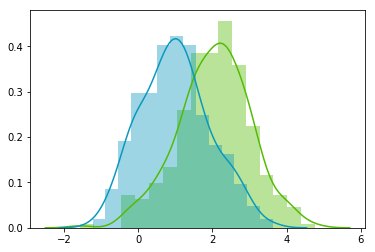

In [266]:
sns.distplot(A[:,0], color="#53BB04")
sns.distplot(A[:,1], color="#0A98BE")
plt.show()
plt.close()

Looks good! We can see that the distributions have equivalent standard deviations but different means (1 and 2). So that's exactly what we have asked for!

Now we can plot our dataset and its covariance matrix with our function:

Covariance matrix:
[[ 0.95171641 -0.0447816 ]
 [-0.0447816   0.87959853]]


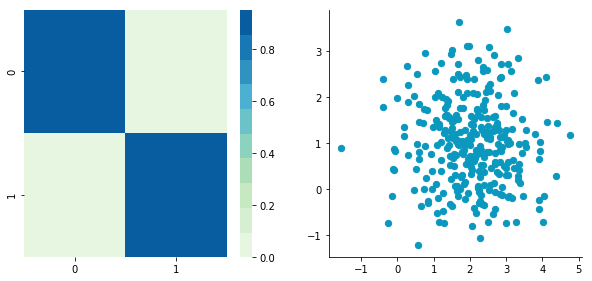

In [267]:
plotDataAndCov(A)
plt.show()
plt.close()

We can see on the scatterplot that the two dimensions are uncorrelated. Note that we have one dimension with a mean of 1 and the other with the mean of 2. Also, the covariance matrix shows that the variance of each variable is very large (around 1) and the covariance of columns 1 and 2 is very small (around 0). Since we insured that the two vectors are independent this is coherent (the opposite is not necessarily true: a covariance of 0 doesn't guaranty independency (see [here](https://stats.stackexchange.com/questions/12842/covariance-and-independence)).

### Correlated data

Now, let's construct dependent data by specifying one column from the other one.

Covariance matrix:
[[ 0.95171641  0.92932561]
 [ 0.92932561  1.12683445]]


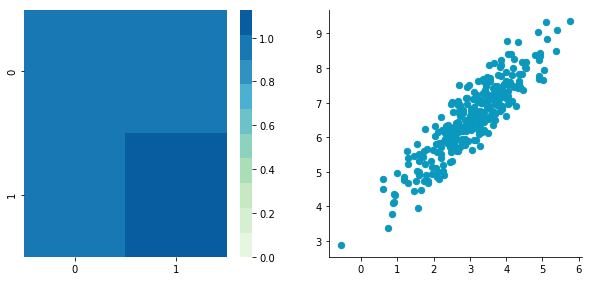

In [268]:
np.random.seed(1234)
b1 =  np.random.normal(3, 1, 300)
b2 = b1 + np.random.normal(7, 1, 300)/2.
B = np.array([b1, b2]).T
plotDataAndCov(B)
plt.show()
plt.close()

The correlation between the two dimensions is visible on the scatter plot. We can see that a line could be drawn and used to predict $\boldsymbol{y}$ from $\boldsymbol{x}$ and vice versa. The covariance matrix is not diagonal (there are non-zero cells outside of the diagonal). That means that the covariance between dimensions is non-zero.

That's great! ⚡️ We now have all the tools to see different preprocessing techniques.

# 2. Preprocessing

## A. Mean normalization

Mean normalization is just removing the mean from each observation.

$$
\bs{X'} = \bs{X} - \bar{x}
$$

where $\bs{X'}$ is the normalized dataset, $\bs{X}$ the original dataset and $\bar{x}$ the mean of $\bs{X}$.

It will have the effect of centering the data around 0. We will create the function `center()` to do that:

In [14]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

Let's give it a try with the matrix $\bs{B}$ we have created above:

Before:


Covariance matrix:
[[ 0.95171641  0.92932561]
 [ 0.92932561  1.12683445]]


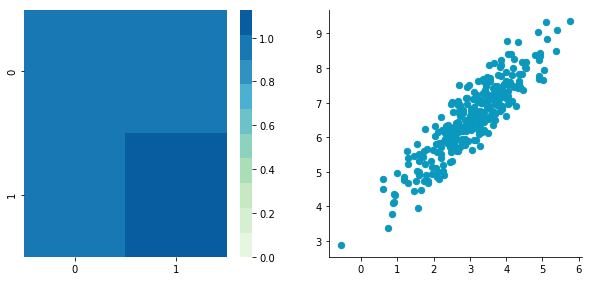

After:


Covariance matrix:
[[ 0.95171641  0.92932561]
 [ 0.92932561  1.12683445]]


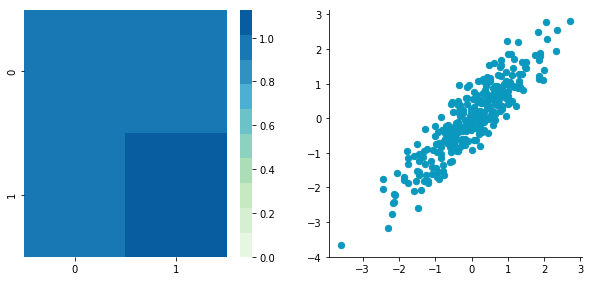

In [270]:
BCentered = center(B)

print 'Before:\n\n'

plotDataAndCov(B)
plt.show()
plt.close()

print 'After:\n\n'

plotDataAndCov(BCentered)
plt.show()
plt.close()

The first plot shows again the original data $\bs{B}$ and the second plot shows the centered data (look at the scale).

## B. Standardization

The standardization is used to put all features on the same scale. The way to do it is to divide each zero-centered dimension by its standard deviation.

$$
\bs{X'} = \frac{\bs{X} - \bar{x}}{\sigma_{\bs{X}}}
$$

where $\bs{X'}$ is the standardized dataset, $\bs{X}$ the original dataset, $\bar{x}$ the mean of $\bs{X}$ and $\sigma_{\bs{X}}$ the standard deviation of $\bs{X}$.

In [324]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

Let's create another dataset with a different scale to check that it is working.

Covariance matrix:
[[ 0.95171641  0.83976242]
 [ 0.83976242  6.22529922]]


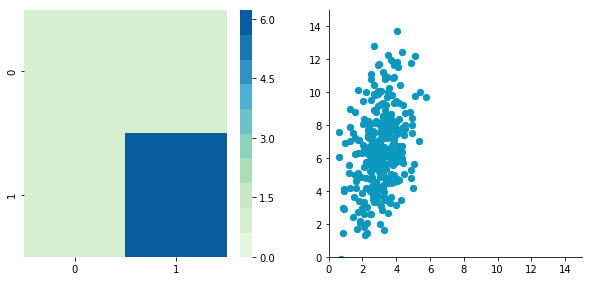

In [325]:
np.random.seed(1234)
c1 =  np.random.normal(3, 1, 300)
c2 = c1 + np.random.normal(7, 5, 300)/2.
C = np.array([c1, c2]).T

plotDataAndCov(C)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.show()
plt.close()

We can see that the scales of $x$ and $y$ are different. Note also that the correlation seems smaller because of the scale differences. Now let's standardise it:

Covariance matrix:
[[ 1.          0.34500274]
 [ 0.34500274  1.        ]]


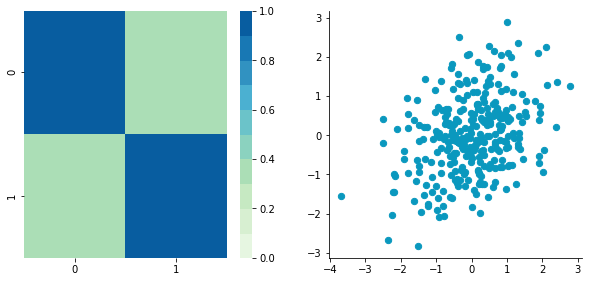

In [326]:
CStandardized = standardize(C)

plotDataAndCov(CStandardized)
plt.show()
plt.close()

Looks good! You can see that the scales are the same and that the dataset is zero-centered according to both axes. Now, have a look at the covariance matrix: you can see that the variance of each coordinate (the top-left cell and the bottom-right cell) is equal to 1. By the way, this new covariance matrix is actually the correlation matrix!💥 The Pearson correlation coefficient between the two variables ($\bs{c1}$ and $\bs{c2}$) is 0.54220151.

## C. Whitening

Whitening or sphering data means that we want to transform it in a way to have a covariance matrix that is the identity matrix (1 in the diagonal and 0 for the other cells; [more details on the identity matrix](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.3-Identity-and-Inverse-Matrices/)). It is called whitening in reference to white noise.

Whitening is a bit more complicated but we now have all the tools that we need to do it. It involves the following steps:

    1- Zero-center the data
    2- Decorrelate the data
    3- Rescale the data
    
Let's take again $\bs{C}$ and try to do these steps.

#### 1. Zero-centering

Covariance matrix:
[[ 0.95171641  0.83976242]
 [ 0.83976242  6.22529922]]


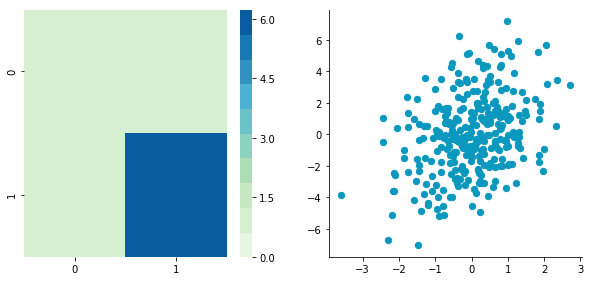

In [327]:
CCentered = center(C)

plotDataAndCov(CCentered)
plt.show()
plt.close()

#### 2. Decorrelate

At this point, we need to decorrelate our data. Intuitively, it means that we want to rotate the data until there is no correlation anymore. Look at the following cartoon to see what I mean:

<img src="images/rotation.png" width="500" alt="Rotation to decorrelate the data" title="The rotation can decorrelate the data.">
<em>The left plot shows correlated data. For instance, if you take a data point with a big $x$ value, chances are that $y$ will also be quite big. Now take all data points and do a rotation (maybe around 45 degrees counterclockwise): the new data (plotted on the right) is not correlated anymore.</em>

The question is: how could we find the right rotation in order to get the uncorrelated data? Actually, it is exactly what the **eigenvectors** of the covariance matrix do: they indicate the direction where the spread of the data is at its maximum:

<img src="images/maxVar.png" width="300" alt="Direction where the variance is maximum" title="There is one direction where the variance is maximum.">
<em>The eigenvectors of the covariance matrix give you the direction that maximizes the variance. The direction of the green line is where the variance is maximum. Just look at the smallest and largest point projected on this line: the spread is big. Compare that with the projection on the orange line: the spread is very small.</em>

For more details about the eigendecomposition, see [this post](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.7-Eigendecomposition/).

So we can decorrelate the data by projecting it on the eigenvectors basis. This will have the effect to apply the rotation needed and remove correlations between the dimensions. Here are the steps:

    1- Calculate the covariance matrix
    2- Calculate the eigenvectors of the covariance matrix
    3- Apply the matrix of eigenvectors to the data (this will apply the rotation)
    
Let's pack that into a function:

In [279]:
def decorrelate(X):
    newX = center(X)
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    return decorrelated

Let's try to decorrelate our zero-centered matrix $\bs{C}$ to see it in action:

Covariance matrix:
[[ 0.95171641  0.83976242]
 [ 0.83976242  6.22529922]]


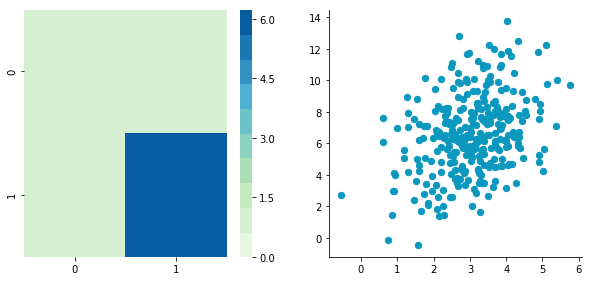

Covariance matrix:
[[  5.96126981e-01  -1.48029737e-16]
 [ -1.48029737e-16   3.15205774e+00]]


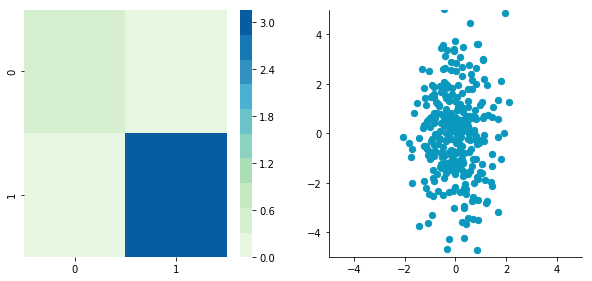

In [276]:
plotDataAndCov(C)
plt.show()
plt.close()

CDecorrelated = decorrelate(CCentered)
plotDataAndCov(CDecorrelated)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()

Nice! This is working 🎄

We can see that the correlation is not here anymore and that the covariance matrix (now a diagonal matrix) confirms that the covariance between the two dimensions is equal to 0.

#### 3. Rescale the data

The next step is to scale the uncorrelated matrix in order to obtain a covariance matrix corresponding to the identity matrix (ones on the diagonal and zeros on the other cells). To do that we scale our decorrelated data by dividing each dimension by the square-root of its corresponding eigenvalue.

In [280]:
def whiten(X):
    newX = center(X)
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

*Note:* we add a small value (here $10^{-5}$) to avoid the division by $0$.

Covariance matrix:
[[  9.99983225e-01  -1.06581410e-16]
 [ -1.06581410e-16   9.99996827e-01]]


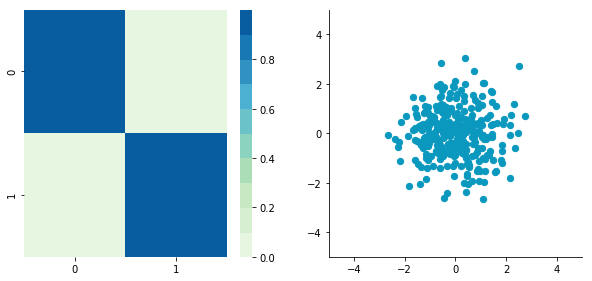

In [281]:
CWhitened = whiten(CCentered)
# whitened_B_cov = whitened_B.T.dot(whitened_B)/whitened_B.shape[0]

# CDecorrelated = decorrelate(CCentered)
plotDataAndCov(CWhitened)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()

Hooray! We can see that with the covariance matrix that this is all good. We have something that really looks to the identity matrix ($1$ on the diagonal and $0$ elsewhere). 🌵

# 3. Image whitening

We will see how whitening can be applied to preprocess image dataset. To do so we will use the paper of [Pal & Sudeep (2016)](https://ieeexplore.ieee.org/document/7808140/) where they give some details about the process. This preprocessing technique is called Zero component analysis (ZCA).

Check out the paper, but here is the kind of result they got:

<img src="images/whitening-images-cifar10-pal-sudeep.png" width="800" alt="Whitening images from the CIFAR10 dataset. Results from the paper of Pal & Sudeep (2016).">
<em>Whitening images from the CIFAR10 dataset. Results from the paper of Pal & Sudeep (2016). The original images (left) and the images after the ZCA (right) are shown.</em>

First thing first: we will load images from the CIFAR dataset. This dataset is available from Keras but you can also download it [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In [283]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train.shape

(50000, 32, 32, 3)

The training set of the CIFAR10 dataset contains 50000 images. The shape of `X_train` is (50000, 32, 32, 3). Each image is 32px by 32px and each pixel contains 3 dimensions (R, G, B). Each value is the brightness of the corresponding color between 0 and 255.

We will start by selecting only a subset of the images, let's say 1000:

In [284]:
X = X_train[:1000]
print X.shape

(1000, 32, 32, 3)


That's better! Now we will reshape the array to have flat image data with one image per row. Each image will be (1, 3072) because $32 \times 32 \times 3 = 3072$. Thus, the array containing all images will be (1000, 3072):

In [285]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
print X.shape

(1000, 3072)


The next step is to be able to see the images. The function `imshow()` from Matplotlib ([doc](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html)) can be used to show images. It needs images with the shape ($M \times N \times 3$) so let's create a function to reshape the images and be able to visualize them from the shape (1, 3072).

In [229]:
def plotImage(X):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X.reshape(32,32,3))
    plt.show()
    plt.close()

For instance, let's plot one of the images we have loaded:

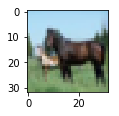

In [286]:
plotImage(X[12, :])

Cute! 🌵

We can now implement the whitening of the images. [Pal & Sudeep (2016)](https://ieeexplore.ieee.org/document/7808140/) describe the process:

1. The first step is to rescale the images to obtain the range [0, 1] by dividing by 255 (the maximum value of the pixels).

Remind that the formula to obtain the range [0, 1] is:

$$\frac{data - min(data)}{max(data) - min(data)}$$

but here, the minimum value is 0, so this leads to:

$$\frac{data}{max(data)} = \frac{data}{255}$$

In [231]:
X_norm = X / 255.
print 'X.min()', X_norm.min()
print 'X.max()', X_norm.max()

X.min() 0.0
X.max() 1.0


### Mean subtraction: per-pixel or per-image?

Ok cool, the range of our pixel values is between 0 and 1 now. The next step is:

2. Subtract the mean from all image.

Be careful here 🌪🎢:

One way to do it is to take each image and remove the mean of this image from every pixel ([Jarrett et al., 2009](https://www.computer.org/csdl/proceedings/iccv/2009/4420/00/05459469.pdf)). The intuition behind this process is that it centers the pixels of each image around 0.

Another way to do it is to take each of the 3072 pixels that we have (32 by 32 pixels for R, G and B) for every image and subtract the mean of that pixel across all images. This is called per-pixel mean subtraction. This time, each pixel will be centered around 0 *according to all images*. When you will feed your network with the images, each pixel is considered as a different feature. With the per-pixel mean subtraction, we have centered each feature (pixel) around 0. This technique is commonly used (e.g [Wan et al., 2013](http://proceedings.mlr.press/v28/wan13.html)).

We will now do the per-pixel mean subtraction from our 1000 images. Our data are organized with these dimensions (images, pixels). It was (1000, 3072) because there are 1000 images with $32 \times 32 \times 3 = 3072$ pixels. The mean per-pixel can thus be obtained from the first axis:

In [232]:
X_norm.mean(axis=0).shape

(3072,)

This gives us 3072 values which is the number of means: one per pixel. Let's see the kind of values we have:

In [233]:
X_norm.mean(axis=0)

array([ 0.5234    ,  0.54323137,  0.5274    , ...,  0.50369804,
        0.50011765,  0.45227451])

This is near 0.5 because we already have normalized to the range [0, 1]. However, we still need to remove the mean from each pixel:

In [234]:
X_norm = X_norm - X_norm.mean(axis=0)

Just to convince ourselves that it worked, we will compute the mean of the first pixel. Let's hope that it is 0.

In [235]:
X_norm.mean(axis=0)

array([ -5.30575583e-16,  -5.98021632e-16,  -4.23439062e-16, ...,
        -1.81965554e-16,  -2.49800181e-16,   3.98570066e-17])

This is not exactly 0 but it is small enough that we can consider that it worked! 🌵

Now we want to calculate the covariance matrix of the zero-centered data. Like we have seen above, we can calculate it with the `np.cov()` function from Numpy. Please note that our variables are our different images. This implies that the variables are the rows of the matrix $\bs{X}$. Just to be clear, we will tell this information to Numpy with the parameter `rowvar=TRUE` even if it is `True` by default (see the [doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)):

In [236]:
cov = np.cov(X_norm, rowvar=True)

Now the magic part: we will calculate the singular values and vectors of the covariance matrix and use them to rotate our dataset. Have a look at [my post](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/) on the singular value decomposition if you need more details!

*Note*: It can take a bit of time with a lot of images and that's why we are using only 1000. In the paper, they used 10000 images. Feel free to compare the results according to how many images you are using:

In [237]:
U,S,V = np.linalg.svd(cov)

In the paper, they used the following equation:

$$
\bs{X}_{ZCA} = \bs{U}.diag(\frac{1}{\sqrt{diag(\bs{S}) + \epsilon}}).\bs{U^\text{T}.X}
$$

with $\bs{U}$ the left singular vectors, and $\bs{S}$ the singular values of the covariance of the initial normalized dataset of images and $\bs{X}$ the normalized dataset. $\epsilon$ is an hyper-parameter called the whitening coefficient. $diag(a)$ corresponds to a matrix with the vector $a$ as a diagonal and 0 in all other cells.

We will try to implement this equation. Let's start by checking the dimensions of the SVD:

In [238]:
print U.shape, S.shape

(1000, 1000) (1000,)


$\bs{S}$ is a vector containing 1000 elements (the singular values). $diag(\bs{S})$ will thus be of shape (1000, 1000) with $\bs{S}$ as the diagonal:

In [239]:
print np.diag(S)
print '\nshape:', np.diag(S).shape

[[  8.15846654e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.68234845e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   2.41075267e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.92727365e-05
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    3.52614473e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.35907202e-15]]

shape: (1000, 1000)


$diag(\frac{1}{\sqrt{diag(\bs{S}) + \epsilon}})$ is also of shape (1000, 1000) as well as $\bs{U}$ and $\bs{U^{\text{T}}}$. We have seen also that $\bs{X}$ has the shape (1000, 3072). The shape of $\bs{X}_{ZCA}$ is thus:

$$
(1000, 1000) . (1000, 1000) . (1000, 3072) = (1000, 1000) . (1000, 3072) = (1000, 3072)
$$

which corresponds to the shape of the initial dataset. Nice!

We have:

In [240]:
epsilon = 0.1
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_norm)

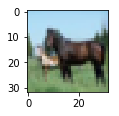

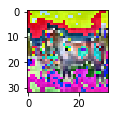

In [241]:
plotImage(X[12, :])
plotImage(X_ZCA[12, :])

In [242]:
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
print 'min:', X_ZCA_rescaled.min()
print 'max:', X_ZCA_rescaled.max()

min: 0.0
max: 1.0


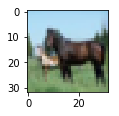

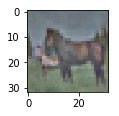

In [243]:
plotImage(X[12, :])
plotImage(X_ZCA_rescaled[12, :])

Hooray! That's great!⚡️It looks like the images from the paper. Actually, they have used 10000 images and not 1000 like us. To see the differences in the results according to the number of images that you use and the effect of the hyper-parameter $\epsilon$, here are the results for different values:

<img src="images/result-image-whitening-cifar10.png" width="400" alt="Different values of epsilon and different number of images used">
<em>The result of the whitening is different according to the number of images that we are using and the value of the hyper-parameter epsilon. The image on the left is the original image. In the paper, [Pal & Sudeep (2016)](https://ieeexplore.ieee.org/document/7808140/) used 10000 images and epsilon = 0.1. This corresponds to the bottom left image.</em>

That's all! 🌴

I hope that you found something interesting in this notebook! You can find it in a nicer layout on my [blog](https://hadrienj.github.io/posts/Preprocessing-data-for-machine-learning-and-deep-learning/), along with other articles!

# References

[K. Jarrett, K. Kavukcuoglu, M. Ranzato, and Y. LeCun, “What is the best multi-stage architecture for object recognition?,” in 2009 IEEE 12th International Conference on Computer Vision, 2009, pp. 2146–2153.
](https://www.computer.org/csdl/proceedings/iccv/2009/4420/00/05459469.pdf)

[A. Krizhevsky, “Learning Multiple Layers of Features from Tiny Images,” Master’s thesis, University of Tront, 2009.
](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.222.9220&rep=rep1&type=pdf)

[Y. A. LeCun, L. Bottou, G. B. Orr, and K.-R. Müller, “Efficient BackProp,” in Neural Networks: Tricks of the Trade, Springer, Berlin, Heidelberg, 2012, pp. 9–48.
](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)

[K. K. Pal and K. S. Sudeep, “Preprocessing for image classification by convolutional neural networks,” in 2016 IEEE International Conference on Recent Trends in Electronics, Information Communication Technology (RTEICT), 2016, pp. 1778–1781.
](https://ieeexplore.ieee.org/document/7808140/)

[L. Wan, M. Zeiler, S. Zhang, Y. L. Cun, and R. Fergus, “Regularization of Neural Networks using DropConnect,” in International Conference on Machine Learning, 2013, pp. 1058–1066.
](http://proceedings.mlr.press/v28/wan13.html)

And also these great ressources and QA:

[Wikipedia - Whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation)

[CS231 - Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/neural-networks-2/)

[Dustin Stansbury - The Clever Machine](https://theclevermachine.wordpress.com/2013/03/30/the-statistical-whitening-transform/)

[Some details about the covariance matrix](http://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/)

[SO - Image whitening in Python](https://stackoverflow.com/questions/41635737/is-this-the-correct-way-of-whitening-an-image-in-python)

[Mean normalization per image or from the entire dataset](http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing)

[Mean subtraction - all images or per image?](https://stackoverflow.com/questions/29743523/subtract-mean-from-image)

[Why centering is important - See section 4.3](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)

[Kaggle kernel on ZCA](https://www.kaggle.com/nicw102168/exploring-zca-and-color-image-whitening/notebook)

[How ZCA is implemented in Keras](https://github.com/keras-team/keras-preprocessing/blob/b9d142456a64ef228475f07cb2f2d38fd05bd249/keras_preprocessing/image.py#L1254:L1257)

In [1]:
!jupyter nbconvert --to markdownJekyll 'Preprocessing-for-deep-learning.ipynb'



[NbConvertApp] Converting notebook Preprocessing-for-deep-learning.ipynb to markdownJekyll
[NbConvertApp] Support files will be in Preprocessing-for-deep-learning_files/
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learning_files
[NbConvertApp] Making directory Preprocessing-for-deep-learn

In [311]:
test = "Preprocessing-data-for-machine-learning-and-deep-learning_files/Preprocessing-data-for-machine-learning-and-deep-learning_23_0.png"

import re

test.split('/')[1]


'Preprocessing-data-for-machine-learning-and-deep-learning_23_0.png'